In [ ]:
# default_exp inference

In [1]:
#export
import tensorflow as tf
from tensorflow.keras.models import load_model
from pathlib import Path
from PIL import Image
import os
import cv2
import numpy as np
from tqdm.notebook import tqdm

from xml.etree.ElementTree import Element, SubElement, tostring 
import pprint
from xml.dom.minidom import parseString


In [2]:
from matplotlib import pyplot as plt
from IPython.display import clear_output


Bad key "text.kerning_factor" on line 4 in
/home/addfor/anaconda3/envs/smart_tray/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
%config Completer.use_jedi = False

In [4]:
#export
def load_image(img_path):
    img = tf.io.read_file(str(img_path))
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def get_bbs(img, model, threshold=0.5):
    img = cv2.resize(img, (400,400), cv2.INTER_AREA)
    out = model(img[None])
    scrs, bbs = out['detection_scores'].numpy(), out['detection_boxes'].numpy()
    return bbs[scrs > threshold], scrs[scrs > threshold]

In [5]:
def draw_bbs(img, bbs, color=[0,0,255]):
    height, width, _ = img.shape
    for ymin, xmin, ymax, xmax in bbs:
        cv2.rectangle(img, (int(xmin*width), int(ymin*height)), (int(xmax*width),int(ymax*height)), color, 10)

def plot(imgs):
    if isinstance(imgs, np.ndarray):
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(imgs)
    else:
        n_imgs = len(imgs)
        fig, axs = plt.subplots(ncols=n_imgs, figsize=(12, 12))
        for ax, img in zip(axs, imgs): ax.imshow(img)

In [6]:
path_det1 = '/home/addfor/projects/smart_tray/20_5006v02-intp-detection-foodv01/det1_model/saved_model'
path_det2 = '/home/addfor/projects/smart_tray/20_5006v02-intp-detection-foodv01/det2_model/saved_model'
det1 = tf.saved_model.load(path_det1)
det2 = tf.saved_model.load(path_det2)

In [7]:
path = Path("/mnt/data/smarttray/dataset_05jul2021_av3b/Test_Empoli_01_06_2021/train/images")
img_paths = [path/img_path for img_path in os.listdir(path)]
img = load_image(img_paths[5]).numpy()
bbs, scrs = get_bbs(img, det1)

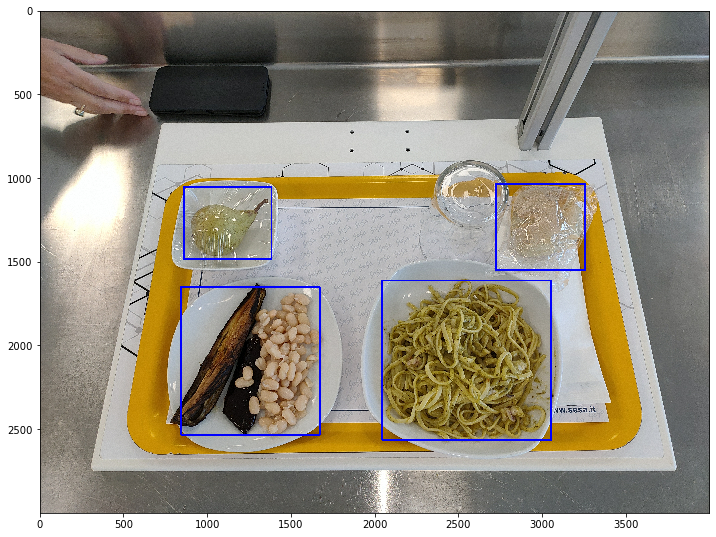

In [8]:
draw_bbs(img, bbs)
plot(img)

In [9]:
def get_bb_crop(img, bb):
    height, width, _ = img.shape
    y1, x1, y2, x2 = bb
    return img[int(height*y1):int(height*y2), int(width*x1):int(width*x2)]

def get_bb_crops(img, bbs): return [get_bb_crop(img, bb) for bb in bbs]

def get_foods_and_recipes(img, det1, det2, multi_piatto_dim=700):
    bbs, scrs = get_bbs(img, det1)
    foods = get_bb_crops(img, bbs)
    foods_rcps = []
    for food in foods:
        h, w, _ = food.shape
        if h > multi_piatto_dim and w > multi_piatto_dim: 
            rcp_bbs, scrs = get_bbs(food, det2)
            rcps = get_bb_crops(food, rcp_bbs)
            foods_rcps.append((food, rcps))
        else:
            foods_rcps.append((food,))           
    return foods_rcps

In [10]:
path = Path("/mnt/data/smarttray/dataset_05jul2021_av3b/Test_Empoli_01_06_2021/train/images")
img_paths = [path/img_path for img_path in os.listdir(path)]

In [11]:
for img_path in img_paths:
    img = load_image(img_path).numpy()
    cv2.resize(img, (400,400), cv2.INTER_AREA)
    results = get_foods_and_recipes(img, det1, det2)
    for result in results:
        if len(result) > 1:
            plot([result[0], *result[1]])
            plt.show()
    x = input("write 'c' to stop")
    clear_output()
    if x=='c': break    

In [12]:
for img_path in img_paths:
    img = load_image(img_path).numpy()
    foods = get_bb_crops(img, get_bbs(img, det1, threshold=0.5)[0])
    for food in foods:
        h, w, _ = food.shape
        if h > 700 and w > 700: 
            draw_bbs(food, get_bbs(food, det2, threshold=0.6)[0])
            plot(food); plt.show()
            x = input("write 'c' to stop")
            clear_output()
            if x=='c': break    
    if x=='c': break    

# Plotting det1 and det2 inference on original image

In [13]:
DATASETS_LIST = [
    "run_3_revisited_5may2021",
    "Sodexo_revisited_8jun",
    "Test_Empoli_01_06_2021",
    "Test_Empoli_08_06_2021",
    "Test_Empoli_09_06_2021",
    "Test_Empoli_26_05_2021",
    "Test_Empoli_27_05_2021",
    "Test_Empoli_28_05_2021",
    "Test_Empoli_29_04_2021",
    "Test_Empoli_30_04_2021",
    "Test_Empoli_31_05_2021",
    "Test_Empoli_from_10_06_2021_to_30_06_2021",
    "UNIMIB_revisited_7giu2021"
]

BASE_PATH = Path('/mnt/data/smarttray/dataset_05jul2021_av3b')

In [14]:
def initialize_pascalvoc_header(img_path, W, H):
    node_root = Element('annotation')

    node_folder = SubElement(node_root, 'folder')
    node_folder.text = f'{BASE_PATH/img_path}'

    node_filename = SubElement(node_root, 'filename')
    node_filename.text = f'{img_path.name}'

    node_size = SubElement(node_root, 'size')
    node_width = SubElement(node_size, 'width')
    node_width.text = f'{W}'

    node_height = SubElement(node_size, 'height')
    node_height.text = f'{H}'

    node_depth = SubElement(node_size, 'depth')
    node_depth.text = '3'
    
    return node_root

def add_bb_to_xml(node_root, bb, scr, class_name):
    node_object = SubElement(node_root, 'object')
    
    node_name = SubElement(node_object, 'name')
    node_name.text = f'{class_name}'
    node_difficult = SubElement(node_object, 'difficult')
    node_difficult.text = '0'
    
    node_bndbox = SubElement(node_object, 'bndbox')
    
    node_xmin = SubElement(node_bndbox, 'xmin')
    node_xmin.text = f'{bb[1]}'
    node_ymin = SubElement(node_bndbox, 'ymin')
    node_ymin.text = f'{bb[0]}'
    node_xmax = SubElement(node_bndbox, 'xmax')
    node_xmax.text = f'{bb[3]}'
    node_ymax = SubElement(node_bndbox, 'ymax')
    node_ymax.text = f'{bb[2]}'
    
    node_score = SubElement(node_bndbox, 'score')
    node_score.text = f'{scr}'

    return node_root

In [18]:
det1_th = 0.4
det2_th = 0.6
blue = [0,0,255]
red  = [255,0,0]

img_id = 0
d = {}
for ds in tqdm(DATASETS_LIST):
    ds_path = BASE_PATH/ds/'val/images'
    try: img_paths = list(ds_path.iterdir())
    except: continue

    for img_path in tqdm(img_paths):
                   
        if img_path.exists() and not img_path.is_dir(): img = load_image(img_path).numpy()
        else: continue

        H, W, _ = img.shape
        
        node_root = initialize_pascalvoc_header(img_path, W, H)
        
        food_bbs, food_scrs = get_bbs(img, det1, threshold=det1_th)
        for (y1,x1,y2,x2), scr  in zip(food_bbs, food_scrs): 
            bb = [int(H*y1), int(W*x1), int(H*y2), int(W*x2)]
            node_root = add_bb_to_xml(node_root, bb, scr, "food")
    
        foods = get_bb_crops(img, food_bbs)
        for food, (Y1, X1, _, _) in zip(foods, food_bbs):
            h, w, _ = food.shape
            if h > 700 and w > 700:
                rcp_bbs, rcp_scrs = get_bbs(food, det2, threshold=det2_th)
                new_rcp_bbs = []
                for (y1,x1,y2,x2), scr  in zip(rcp_bbs, rcp_scrs): 
                    bb = [int(h*y1 + H*Y1), int(w*x1 + W*X1), int(h*y2 + H*Y1), int(w*x2 + W*X1)]
                    new_rcp_bbs.append(bb)
                    node_root = add_bb_to_xml(node_root, bb, scr, "recipe")                
                
                ### Code snippets for drawing/debbuging ###
                draw_bbs(img, food_bbs, color=blue)
                draw_bbs(img, new_rcp_bbs, color=red)

                plot(img); plt.show()
                x = input("write 'c' to stop")
                clear_output()
                if x=='c': raise Exception() 
                ###########################################

        xml = tostring(node_root) #, pretty_print=True Formatted display, the newline of the newline
        dom = parseString(xml)
        
        xml_base_path = BASE_PATH/'two_detector_results'/ds
        xml_base_path.mkdir(exist_ok=True)
        with open(str(xml_base_path/f'{img_path.stem}.xml'), 'w') as f: dom.writexml(f,indent='   ', addindent='   ', newl='\n')
        
#         xml_base_path = BASE_PATH
#         with open(str(xml_base_path/f'{img_path.stem}.xml'), 'w') as f: dom.writexml(f)
            
        img_id += 1
        
#         if x=='c': break    

Exception: 

In [128]:
import xml.etree.ElementTree as ET

def read_xml_content(xml_file: str):                                                                                                                                                                                                                                      
    tree = ET.parse(xml_file)                                                                                                                                                                                                                                                   
    root = tree.getroot()                                                                                                                                                                                                                                                       
    list_with_all_boxes = []                                                                                                                                                                                                                                                    
    for boxes in root.iter('object'):
        
        class_name = boxes.find("name").text                                                                                                                                                                                                                                          
        ymin, xmin, ymax, xmax = None, None, None, None                                                                                                                                                                                                                         
        ymin = int(float(boxes.find("bndbox/ymin").text))                                                                                                                                                                                                                       
        xmin = int(float(boxes.find("bndbox/xmin").text))                                                                                                                                                                                                                       
        ymax = int(float(boxes.find("bndbox/ymax").text))                                                                                                                                                                                                                       
        xmax = int(float(boxes.find("bndbox/xmax").text))        
        list_with_all_boxes.append([class_name, xmin, ymin, xmax, ymax])
        
    return list_with_all_boxes

bbs = read_xml_content('/mnt/data/smarttray/dataset_05jul2021_av3b/two_detector_results/run_3_revisited_5may2021/1606821829128_12.xml')
img  = load_image('/mnt/data/smarttray/dataset_05jul2021_av3b/run_3_revisited_5may2021/val/images/1606821829128_12.jpg').numpy()

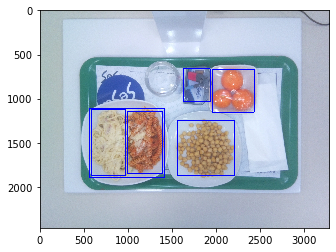

In [129]:
h,w,_ = img.shape
bbs = [[y1/h,x1/w,y2/h,x2/w] for _,x1,y1,x2,y2 in bbs]
draw_bbs(img, bbs)
plt.imshow(img)